<a href="https://colab.research.google.com/github/RichRussell91/data_science_practice/blob/main/Ames_Housing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [54]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import xgboost as xgb
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten

In [55]:

file = 'train.csv'
path = 'test.csv'
train = pd.read_csv(file)
test = pd.read_csv(path)

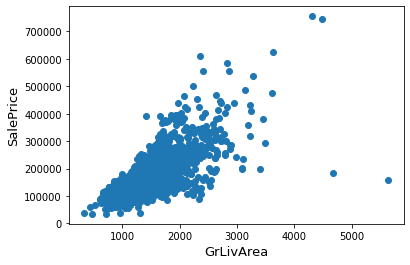

In [56]:
# Locate outliers in dataset
fig, ax = plt.subplots()
ax.scatter(x = train['GrLivArea'], y = train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()
# Bottom right two dots are outliers

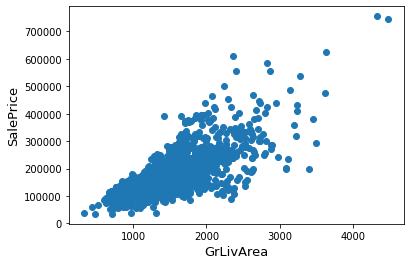

In [57]:
# Delete the outliers identified in previous cell
train = train.drop(train[(train['GrLivArea']>4000) &
                         (train['SalePrice']<300000)].index)

# Check outliers removed correctly using graph
fig, ax = plt.subplots()
ax.scatter(train['GrLivArea'], train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show();

In [58]:
# replaces zero value with NaNs

num_missing = (train == 0).sum()
train = train.replace(0, np.nan)

In [59]:
# iterates through columns in X, and adds column to cols
# if column has >30% of values missing

cols = []
for i in range(train.shape[1]):
  n_miss = train.iloc[:, i].isnull().sum()
  perc = n_miss / train.shape[0] * 100
  if perc > 30:
    cols.append(i)

In [60]:
# takes columns that have >30% of values missing and returns
# their names, then drops those columns from X

columns = []
for i in cols:
  columns.append(train.iloc[:, i].name)
print(columns)
train = train.drop(columns, axis=1)
print(train.shape)

['Alley', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', '2ndFlrSF', 'LowQualFinSF', 'BsmtFullBath', 'BsmtHalfBath', 'HalfBath', 'Fireplaces', 'FireplaceQu', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'PoolQC', 'Fence', 'MiscFeature', 'MiscVal']
(1458, 60)


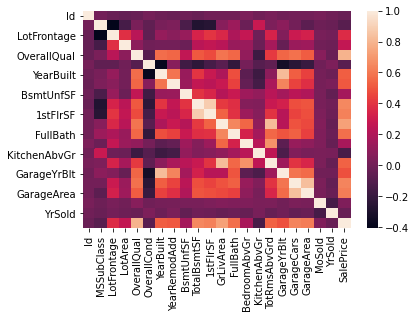

In [61]:

corr = train.corr()
sns.heatmap(corr)

In [62]:

# delete features that have a <20% correlation with the SalePrice

corr_sales_price = abs(corr["SalePrice"])
relevant_features = corr_sales_price[corr_sales_price>0.2]
train = train[relevant_features.index]

In [63]:
# Fill remaining N/A values with either 0 or 1, depending on the feature

train[['LotFrontage', 'TotalBsmtSF', 'GarageYrBlt', 'GarageCars', 'GarageArea']] = train[['LotFrontage', 'TotalBsmtSF', 'GarageYrBlt', 'GarageCars', 'GarageArea']].fillna(0)
train.FullBath = train.FullBath.fillna(1)

In [64]:
train.head()

,LotFrontage,LotArea,OverallQual,YearBuilt,YearRemodAdd,TotalBsmtSF,1stFlrSF,GrLivArea,FullBath,TotRmsAbvGrd,GarageYrBlt,GarageCars,GarageArea,SalePrice
0,65.0,8450,7,2003,2003,856.0,856,1710,2.0,8,2003.0,2.0,548.0,208500
1,80.0,9600,6,1976,1976,1262.0,1262,1262,2.0,6,1976.0,2.0,460.0,181500
2,68.0,11250,7,2001,2002,920.0,920,1786,2.0,6,2001.0,2.0,608.0,223500
3,60.0,9550,7,1915,1970,756.0,961,1717,1.0,7,1998.0,3.0,642.0,140000
4,84.0,14260,8,2000,2000,1145.0,1145,2198,2.0,9,2000.0,3.0,836.0,250000


In [65]:
# perform RFE feature selection on the remaining features
# using Linear Regression as the base model

X = train.loc[:, 'LotFrontage': 'GarageArea']
y = pd.DataFrame(train.loc[:, 'SalePrice'])

model = LinearRegression()

rfe = RFE(model, 5)

X_rfe = rfe.fit_transform(X, y)

model.fit(X_rfe, y)
print(rfe.support_)
print(rfe.ranking_)

[False False  True False  True False False False  True  True False  True
 False]
[3 9 1 2 1 5 7 4 1 1 8 1 6]


In [66]:
X = train.loc[:, 'LotFrontage':'GarageArea']
y = pd.DataFrame(train.loc[:, 'SalePrice'])

In [67]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [68]:
# Define Neural Network

NN_model = Sequential()

# Define Input Layer:
NN_model.add(Dense(128, kernel_initializer='normal', input_dim=X_train.shape[1], activation='relu'))

# Define Hidden Layers:
NN_model.add(Dense(256, kernel_initializer='normal', activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal', activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal', activation='relu'))

# Define Output Layer:
NN_model.add(Dense(1, kernel_initializer='normal'))

# Compile the network:
NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
NN_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_20 (Dense)             (None, 128)               1792      
_________________________________________________________________
dense_21 (Dense)             (None, 256)               33024     
_________________________________________________________________
dense_22 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_23 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_24 (Dense)             (None, 1)                 257       
Total params: 166,657
Trainable params: 166,657
Non-trainable params: 0
_________________________________________________________________


In [69]:
# Define a checkpoint callback:

checkpoint_name = 'Weights-{epoch:03d}--{val_loss:.5f}.hdf5'
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only=True, mode='auto')
callbacks_list = [checkpoint]

In [70]:
NN_model.fit(X_train, y_train, epochs=500, batch_size=32, validation_split = 0.2, callbacks=callbacks_list, verbose=0)


Epoch 00001: val_loss improved from inf to 59572.45703, saving model to Weights-001--59572.45703.hdf5

Epoch 00002: val_loss improved from 59572.45703 to 42743.33203, saving model to Weights-002--42743.33203.hdf5

Epoch 00003: val_loss improved from 42743.33203 to 38558.80469, saving model to Weights-003--38558.80469.hdf5

Epoch 00004: val_loss improved from 38558.80469 to 36461.60156, saving model to Weights-004--36461.60156.hdf5

Epoch 00005: val_loss improved from 36461.60156 to 34307.28516, saving model to Weights-005--34307.28516.hdf5

Epoch 00006: val_loss improved from 34307.28516 to 33547.17188, saving model to Weights-006--33547.17188.hdf5

Epoch 00007: val_loss improved from 33547.17188 to 32232.53906, saving model to Weights-007--32232.53906.hdf5

Epoch 00008: val_loss did not improve from 32232.53906

Epoch 00009: val_loss improved from 32232.53906 to 28355.80078, saving model to Weights-009--28355.80078.hdf5

Epoch 00010: val_loss improved from 28355.80078 to 27516.67773,

In [71]:
# make predictions using our Neural Network that has now been trained

# load weights file of the best model, which can be found in the output of the NN model's training:
weights_file = 'Weights-406--23883.03516.hdf5'
NN_model.load_weights(weights_file)
NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])

y_pred = NN_model.predict(X_test)
NN_MAE = mean_absolute_error(y_test, y_pred)
print('Neural Network MAE = ', NN_MAE)

Neural Network MAE =  25955.15076519692


In [72]:
# Define and fit a Random Forest Regressor model

rfr_model = RandomForestRegressor()
rfr_model.fit(X_train, y_train)

predicted_prices = rfr_model.predict(X_test)
rfr_MAE = mean_absolute_error(y_test, predicted_prices)
print('Random forest validation MAE = ', rfr_MAE)

Random forest validation MAE =  19690.92720319635


In [73]:
# Define and fit an XGBoost Regressor model

XGBModel = XGBRegressor()
XGBModel.fit(X_train, y_train, verbose=False)

# Get MAE on the validation data :
XGBpredictions = XGBModel.predict(X_test)
XGB_MAE = mean_absolute_error(y_test, XGBpredictions)
print('XGBoost validation MAE = ', XGB_MAE)

[13:51:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBoost validation MAE =  19093.16505244007
